# We are going to evaluate Gytis's| SAE. 

What are its statistics? 

How does it compare to language SAEs? 


We will take the code from Gytis's original colab: https://colab.research.google.com/drive/1m6IRqKaRUWRL-d2PC82nslb7kmAgjoKV?usp=sharing#scrollTo=ZDW2Ipyn9Xl7

## Load Gytis SAE into the Prisma library, and sanity check against the original Gytis SAE

First, we load the original model that Gytis uses into the Prisma library's HookedViT class, which allows us to easily cache activations. We are going to compare the outputs of the original model with the HookedViT as a sanity check.

In [1]:
import torch

import sys
from diffusers import KandinskyV22Pipeline, KandinskyV22PriorPipeline
import torch
import PIL
import torch
from diffusers.utils import load_image
from torchvision import transforms
from transformers import CLIPVisionModelWithProjection
from diffusers.models import UNet2DConditionModel
import numpy as np
import os
import importlib.util
import huggingface_hub


In [2]:
DEVICE = 'cuda'
torch.set_grad_enabled(False)
torch.manual_seed(42)


In [3]:
import os

HF_HOME = '/network/scratch/s/sonia.joseph/hf_cache'
os.environ['HF_HOME'] = HF_HOME
os.environ['TRANSFORMERS_CACHE'] = os.path.join(os.environ['HF_HOME'], 'transformers')
os.environ['HF_DATASETS_CACHE'] = os.path.join(os.environ['HF_HOME'], 'datasets')
os.environ['HF_METRICS_CACHE'] = os.path.join(os.environ['HF_HOME'], 'metrics')
os.environ['HF_HUB_CACHE'] = os.path.join(os.environ['HF_HOME'], 'hub')


# !rm -rf ~/.cache/huggingface
print("HF Home:", os.environ.get('HF_HOME', 'Not set'))


HF Home: /network/scratch/s/sonia.joseph/hf_cache


In [4]:
import os
print(os.environ.get("HF_HOME"))
print(os.environ.get("TRANSFORMERS_CACHE"))


/network/scratch/s/sonia.joseph/hf_cache
/network/scratch/s/sonia.joseph/hf_cache/transformers


In [5]:
# Load the Prisma HookedViT model
from vit_prisma.models.model_loader import load_hooked_model
from pathlib import Path


def load_prisma_model():
    model = load_hooked_model('open-clip:laion/CLIP-ViT-bigG-14-laion2B-39B-b160k')
    model.half().to(DEVICE)
    model.cfg.normalize_output = False
    return model

# Load the original Gytis Model
def load_kadinsky():
    image_encoder = CLIPVisionModelWithProjection.from_pretrained(
        'kandinsky-community/kandinsky-2-2-prior',
        subfolder='image_encoder',
        cache_dir=HF_HOME
    ).half().to(DEVICE)

    unet = UNet2DConditionModel.from_pretrained(
        'kandinsky-community/kandinsky-2-2-decoder',
        subfolder='unet',
        cache_dir=HF_HOME
    ).half().to(DEVICE)

    prior = KandinskyV22PriorPipeline.from_pretrained(
        'kandinsky-community/kandinsky-2-2-prior',
        image_encoder=image_encoder,
        torch_dtype=torch.float16,
        cache_dir=HF_HOME
    ).to(DEVICE)

    decoder = KandinskyV22Pipeline.from_pretrained(
        'kandinsky-community/kandinsky-2-2-decoder',
        unet=unet,
        torch_dtype=torch.float16,
        cache_dir=HF_HOME
    ).to(DEVICE)

    del image_encoder, unet

    zero_embed = prior.get_zero_embed()

    return _, _, decoder, zero_embed



_, _, decoder, zero_embed = load_kadinsky()


/home/mila/s/sonia.joseph/env/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.

2025-06-01 23:44:12 DEBUG:urllib3.connectionpool: Starting new HTTPS connection (1): huggingface.co:443
2025-06-01 23:44:12 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /kandinsky-community/kandinsky-2-2-prior/resolve/main/image_encoder/config.json HTTP/1.1" 200 0
2025-06-01 23:44:12 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /kandinsky-community/kandinsky-2-2-prior/resolve/main/image_encoder/config.json HTTP/1.1" 200 0
2025-06-01 23:44:18 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /kandinsky-community/kandinsky-2-2-decoder/resolve/main/unet/config.json HTTP/1.1" 200 0
2025-06-01 23:44:18 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "H

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

2025-06-01 23:44:33 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "GET /api/models/kandinsky-community/kandinsky-2-2-decoder HTTP/1.1" 200 2388
2025-06-01 23:44:33 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /kandinsky-community/kandinsky-2-2-decoder/resolve/main/model_index.json HTTP/1.1" 200 0


Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
model = load_hooked_model('open-clip:laion/CLIP-ViT-bigG-14-laion2B-39B-b160k').half().to(DEVICE)
model.cfg.normalize_output = False
model.cfg.dtype = torch.float16


2025-06-01 23:44:35 INFO:root: Model 'open-clip:laion/CLIP-ViT-bigG-14-laion2B-39B-b160k' is supported and passes tests.
2025-06-01 23:44:35 INFO:root: model_id download_pretrained_from_hf: laion/CLIP-ViT-bigG-14-laion2B-39B-b160k
2025-06-01 23:44:35 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /laion/CLIP-ViT-bigG-14-laion2B-39B-b160k/resolve/main/open_clip_config.json HTTP/1.1" 200 0
2025-06-01 23:44:43 INFO:root: model_id download_pretrained_from_hf: laion/CLIP-ViT-bigG-14-laion2B-39B-b160k
2025-06-01 23:44:43 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /laion/CLIP-ViT-bigG-14-laion2B-39B-b160k/resolve/main/open_clip_pytorch_model.bin HTTP/1.1" 302 0
2025-06-01 23:44:46 INFO:root: visual projection shape: torch.Size([1664, 1280])
2025-06-01 23:44:53 INFO:root: Loaded pretrained model open-clip:laion/CLIP-ViT-bigG-14-laion2B-39B-b160k into HookedTransformer


2025-06-01 23:44:58 DEBUG:urllib3.connectionpool: Starting new HTTPS connection (1): images.featurelab.xyz:443
2025-06-01 23:44:59 DEBUG:urllib3.connectionpool: https://images.featurelab.xyz:443 "GET /example_1.jpg HTTP/1.1" 200 161049
2025-06-01 23:44:59 DEBUG:PIL.TiffImagePlugin: tag: ExifIFD (34665) - type: long (4) - value: b'\x00\x00\x00\x1a'


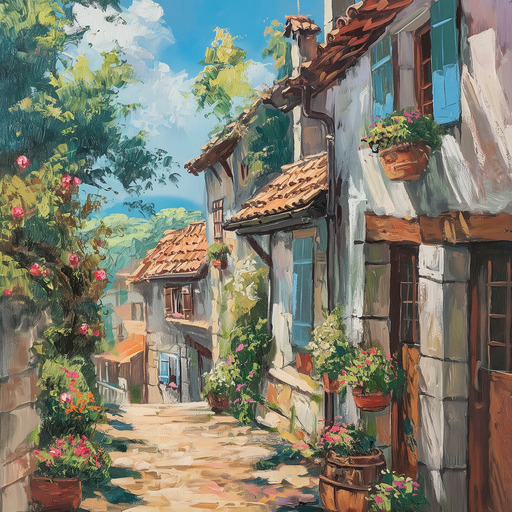

In [7]:
img = load_image("https://images.featurelab.xyz/example_1.jpg")
img


In [8]:
from vit_prisma.transforms.model_transforms import get_clip_val_transforms

from torch.cuda.amp import autocast

with autocast():
    transforms = get_clip_val_transforms()
    transformed_image = transforms(img).to(DEVICE).unsqueeze(0).half()
    prisma_output = model(transformed_image)

Now we will load the Gytis SAE, and the corresponding Prisma SAE, which we reformatted to be compatible with the Prisma library. We will check that the outputs match here too.

In [9]:
from huggingface_hub import hf_hub_download
import importlib
import vit_prisma
import torch
importlib.reload(vit_prisma)
from vit_prisma.sae.sae import SparseAutoencoder

def load_and_test_sae(repo_id):
    """
    Load and test SAE from HuggingFace
    """
    try:
        print(f"Loading model from {repo_id}...")

        # Download files and get paths
        sae_path = hf_hub_download(repo_id, 'weights.pt')
        config_path = hf_hub_download(repo_id, 'config.json')
        
        print(f"SAE path: {sae_path}")
        print(f"Config path: {config_path}")
        
        # Verify files exist
        import os
        if not os.path.exists(config_path):
            raise FileNotFoundError(f"Config file not found at {config_path}")
        if not os.path.exists(sae_path):
            raise FileNotFoundError(f"Weights file not found at {sae_path}")

        sae = SparseAutoencoder.load_from_pretrained(sae_path, config_path=config_path)
        print(sae)
        print(f"SAE config type: {type(sae.cfg)}")

        # Move to available device
        device = "cuda" if torch.cuda.is_available() else "cpu"
        sae = sae.to(device)
        print(f"Using device: {device}")

        return sae

    except Exception as e:
        print(f"Error loading SAE: {str(e)}")
        raise

# Try loading the model
sae = load_and_test_sae('Prisma-Multimodal/CLIP_ViT_bigG_SAE_adapted')

2025-06-01 23:45:00 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /Prisma-Multimodal/CLIP_ViT_bigG_SAE_adapted/resolve/main/weights.pt HTTP/1.1" 302 0


Loading model from Prisma-Multimodal/CLIP_ViT_bigG_SAE_adapted...


2025-06-01 23:45:00 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /Prisma-Multimodal/CLIP_ViT_bigG_SAE_adapted/resolve/main/config.json HTTP/1.1" 200 0


SAE path: /home/mila/s/sonia.joseph/.cache/huggingface/hub/models--Prisma-Multimodal--CLIP_ViT_bigG_SAE_adapted/snapshots/843321fe160a9cf28c61b5cfe65023be20850a11/weights.pt
Config path: /home/mila/s/sonia.joseph/.cache/huggingface/hub/models--Prisma-Multimodal--CLIP_ViT_bigG_SAE_adapted/snapshots/843321fe160a9cf28c61b5cfe65023be20850a11/config.json


2025-06-01 23:45:01 INFO:root: n_tokens_per_buffer (millions): 0.032
2025-06-01 23:45:01 INFO:root: Lower bound: n_contexts_per_buffer (millions): 0.00064
2025-06-01 23:45:01 INFO:root: Total training steps: 158691
2025-06-01 23:45:01 INFO:root: Total training images: 13000000
2025-06-01 23:45:01 INFO:root: Total wandb updates: 15869
2025-06-01 23:45:01 INFO:root: Expansion factor: 128
2025-06-01 23:45:01 INFO:root: n_tokens_per_feature_sampling_window (millions): 204.8
2025-06-01 23:45:01 INFO:root: n_tokens_per_dead_feature_window (millions): 1024.0
2025-06-01 23:45:01 INFO:root: We will reset the sparsity calculation 158 times.
2025-06-01 23:45:01 INFO:root: Number tokens in sparsity calculation window: 4.10e+06
2025-06-01 23:45:01 INFO:root: Using Ghost Grads.
2025-06-01 23:45:01 INFO:root: Gradient clipping with max_norm=1.0
2025-06-01 23:45:01 INFO:root: Using SAE initialization method: encoder_transpose_decoder
2025-06-01 23:45:02 INFO:root: get_activation_fn received: activatio

StandardSparseAutoencoder(
  (hook_sae_in): HookPoint()
  (hook_hidden_pre): HookPoint()
  (hook_hidden_post): HookPoint()
  (hook_sae_out): HookPoint()
  (activation_fn): ReLU()
)
SAE config type: <class 'vit_prisma.sae.config.VisionModelSAERunnerConfig'>
Using device: cuda


In [10]:


def get_error(embed, model, gytis=False):
    if not gytis:
        sae_out, feature_act, *data = model.encode(embed)
    else:
        feature_act = model.encode(embed)
    print("feature act shape", feature_act.shape)
    decoded = model.decode(feature_act)
    error = embed - decoded
    return error


def embed_image(item):
    return prior.interpolate([item], [1]).image_embeds[0]

def generate_one(image_embeds):
    generator = torch.Generator("cuda")
    generator.manual_seed(1)
    images = decoder(
        image_embeds=image_embeds.unsqueeze(0),
        negative_image_embeds=zero_embed,
        height=512,
        width=512,
        num_inference_steps=18,
        num_images_per_prompt=1,
        generator=generator,
    ).images

    return images[0]

def print_top_10(features):
    top_10 = features.argsort()[-10:]
    top_10 = reversed(top_10)

    for idx in top_10:
        print(f"Feature {idx:10d} = {features[idx]:.2f} (https://www.featurelab.xyz/features/{idx})")


In [11]:
sae_out, feature_act, *data = sae.encode(prisma_output)
print_top_10(feature_act[0])

Feature      15331 = 13.63 (https://www.featurelab.xyz/features/15331)
Feature     129002 = 13.58 (https://www.featurelab.xyz/features/129002)
Feature      74498 = 12.84 (https://www.featurelab.xyz/features/74498)
Feature      13804 = 12.83 (https://www.featurelab.xyz/features/13804)
Feature     122007 = 12.82 (https://www.featurelab.xyz/features/122007)
Feature     158849 = 12.44 (https://www.featurelab.xyz/features/158849)
Feature      27586 = 12.23 (https://www.featurelab.xyz/features/27586)
Feature     162970 = 12.08 (https://www.featurelab.xyz/features/162970)
Feature      50178 = 11.66 (https://www.featurelab.xyz/features/50178)
Feature     163352 = 11.43 (https://www.featurelab.xyz/features/163352)


feature act shape torch.Size([163840])


  0%|          | 0/18 [00:00<?, ?it/s]

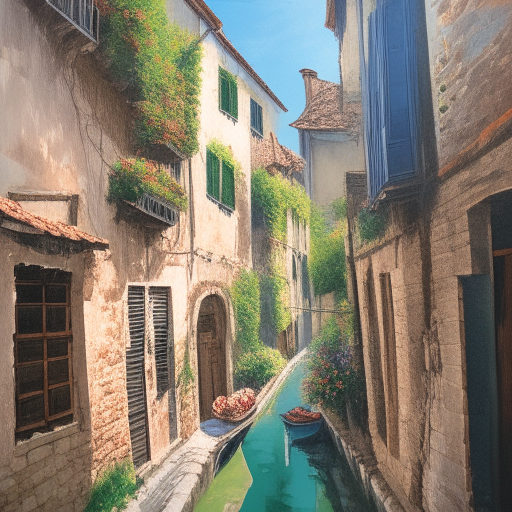

In [12]:
# # # Gytis version

# # # Venitian canals
# # # https://www.featurelab.xyz/features/22420

feature_act[:,22420] = 40

generate_one(sae.decode(feature_act.squeeze(0)) + get_error(prisma_output.squeeze(0), sae))

# Steering

2025-06-01 23:45:04 DEBUG:urllib3.connectionpool: Starting new HTTPS connection (1): images.featurelab.xyz:443
2025-06-01 23:45:04 DEBUG:urllib3.connectionpool: https://images.featurelab.xyz:443 "GET /example_2.jpg HTTP/1.1" 200 93650


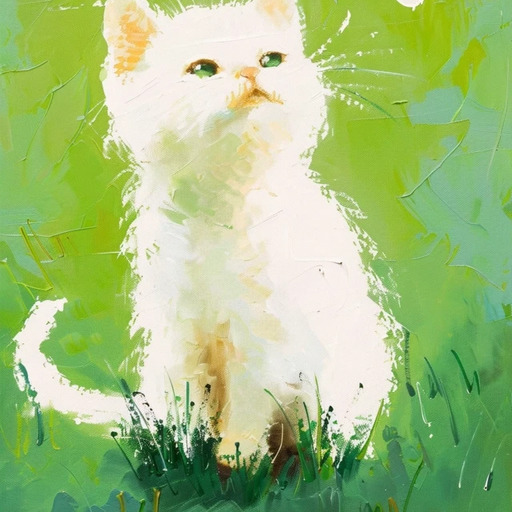

In [13]:
img = load_image("https://images.featurelab.xyz/example_2.jpg")
img

In [14]:
transformed_image = get_clip_val_transforms()(img).to(DEVICE).unsqueeze(0).half()

with torch.cuda.amp.autocast():
    prisma_embed = model(transformed_image)

    sae_out, features, *data = sae.encode(prisma_embed)

    features[:,147026] = 20

    new_img = generate_one(sae.decode(features.squeeze(0)) + get_error(prisma_embed.squeeze(0), sae))

feature act shape torch.Size([163840])


  0%|          | 0/18 [00:00<?, ?it/s]

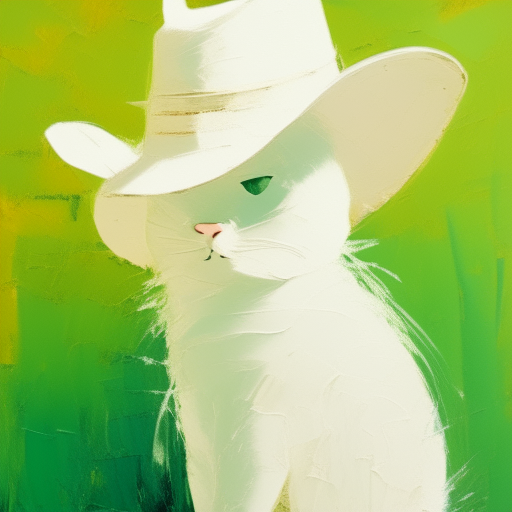

In [15]:
new_img

# Run statistics

In [16]:

from vit_prisma.sae import SparsecoderEval

# Reload the module
importlib.reload(importlib.import_module('vit_prisma.sae'))

# Re-import after reload
from vit_prisma.sae import SparsecoderEval

sae.to(DEVICE)
sae.cfg.device = DEVICE
sae.device=DEVICE
model.to(DEVICE)
model.cfg.device = DEVICE
sae.cfg.hook_point_filters = "output" # We are training the SAE on the output embedding (opposed to intermediate activations), so we set this to "output"
# sae.cfg.hook_point = "output"
print(sae.cfg)


VisionModelSAERunnerConfig(model_class_name='HookedViT', model_name='laion/CLIP-ViT-bigG-14-laion2B-39B-b160k', vit_model_cfg=None, model_path=None, hook_point_layer=None, layer_subtype='hook_resid_post', hook_point_head_index=None, context_size=50, use_cached_activations=False, use_patches_only=False, cached_activations_path='activations/_network_scratch_s_sonia.joseph_datasets_kaggle_datasets/laion_CLIP-ViT-bigG-14-laion2B-39B-b160k/blocks.None.hook_resid_post', image_size=224, architecture='standard', b_dec_init_method='geometric_median', expansion_factor=128, from_pretrained_path=None, is_transcoder=False, transcoder_with_skip_connection=True, out_hook_point_layer=9, layer_out_subtype='hook_mlp_out', d_out=768, _device='cuda', seed=42, _dtype='float32', d_in=1280, activation_fn_str='relu', activation_fn_kwargs={}, cls_token_only=False, max_grad_norm=1.0, initialization_method='encoder_transpose_decoder', normalize_activations=None, n_batches_in_buffer=20, store_batch_size=32, num_w

In [17]:
# Evaluate vision SAE
from torchvision.datasets.folder import default_loader

from torchvision.datasets import DatasetFolder
from torchvision import transforms


transform = transforms.Compose([
    *get_clip_val_transforms().transforms,  # unpack existing transforms
    transforms.Lambda(lambda x: x.half())   # convert to float16
])

sae = sae.half()

dataset =DatasetFolder(
            root='/network/scratch/s/sonia.joseph/datasets/kaggle_datasets/ILSVRC/Data/CLS-LOC/val',
            loader=default_loader,
            extensions=('.jpg', '.jpeg', '.png'),
            transform=transform
        )
# add half precision to transform
eval_runner = SparsecoderEval(sae, model, dataset, max_images=2)

with autocast():
    metrics = eval_runner.run_eval(is_clip=True)



2025-06-01 23:45:07 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /laion/CLIP-ViT-bigG-14-laion2B-39B-b160k/resolve/main/open_clip_pytorch_model.bin HTTP/1.1" 302 0
2025-06-01 23:45:08 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /laion/CLIP-ViT-bigG-14-laion2B-39B-b160k/resolve/main/open_clip_config.json HTTP/1.1" 200 0
2025-06-01 23:45:08 INFO:root: Loaded hf-hub:laion/CLIP-ViT-bigG-14-laion2B-39B-b160k model config.
2025-06-01 23:45:22 INFO:root: Loading pretrained hf-hub:laion/CLIP-ViT-bigG-14-laion2B-39B-b160k weights (/home/mila/s/sonia.joseph/.cache/huggingface/hub/models--laion--CLIP-ViT-bigG-14-laion2B-39B-b160k/snapshots/743c27bd53dfe508a0ade0f50698f99b39d03bec/open_clip_pytorch_model.bin).
2025-06-01 23:45:29 DEBUG:urllib3.connectionpool: https://huggingface.co:443 "HEAD /laion/CLIP-ViT-bigG-14-laion2B-39B-b160k/resolve/main/open_clip_config.json HTTP/1.1" 200 0
2025-06-01 23:47:18 INFO:vit_prisma.sae.evals.model_eval: Starting SparseCoder 